In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Define Hx
def define_Hx(u,v,nu,dx,nx):
    #intialize u and v matrices
    un = u.copy()
    vn = v.copy()
    #intialize Hx matrices
    Hx_n = np.zeros([nx,nx])
    Hx_n_1 = np.zeros([nx,nx])
    #form convection matrices in y
    conv_x = np.zeros_like(un)
    conv_x_1 = np.zeros_like(un)
    conv_x[1:-1,1:-1] = (1/dx)*(un[1:-1,1:-1]*(un[2:,1:-1]-un[1:-1,1:-1])+vn[1:-1,1:-1]*(un[1:-1,2:]-un[1:-1,1:-1]))
    conv_x_1[1:-1,1:-1] = conv_x[:-2,1:-1]
    #form diffusion matrices in y
    diff_n = np.zeros_like(un)
    diff_n_1 = np.zeros_like(un)
    diff_n[1:-1,1:-1] = (nu/dx**2)*(un[2:,1:-1] - 2*un[1:-1,1:-1] + un[:-2,1:-1] + un[1:-1,2:] - 2*un[1:-1,1:-1] + un[1:-1,:-2] )
    diff_n_1[1:-1,1:-1] = diff_n[:-2,1:-1]
    #form final Hx(i,j) and Hx(i-1,j) 
    Hx_n = conv_x + diff_n
    Hx_n_1 = conv_x_1 + diff_n_1

    return Hx_n,Hx_n_1       

In [3]:
#Define Hy
def define_Hy(u,v,nu,dx,nx):
    #intialize u and v matrices
    un = u.copy()
    vn = v.copy()
    #intialize Hy matrices
    Hy_n = np.zeros([nx,nx])
    Hy_n_1 = np.zeros([nx,nx])
    #form convection matrices in y
    conv_y = np.zeros_like(un)
    conv_y_1 = np.zeros_like(un)
    conv_y[1:-1,1:-1] = (1/dx)*(un[1:-1,1:-1]*(vn[2:,1:-1]-vn[1:-1,1:-1])+vn[1:-1,1:-1]*(vn[1:-1,2:]-vn[1:-1,1:-1]))
    conv_y_1[1:-1,1:-1] = conv_y[1:-1,:-2]
    #form diffusion matrices in y
    diff_n = np.zeros_like(un)
    diff_n_1 = np.zeros_like(un)
    diff_n[1:-1,1:-1] = (nu/dx**2)*(vn[2:,1:-1] - 2*vn[1:-1,1:-1] + vn[:-2,1:-1] + vn[1:-1,2:] - 2*vn[1:-1,1:-1] + vn[1:-1,:-2] )
    diff_n_1[1:-1,1:-1] = diff_n[:-2,1:-1]
    #form final Hy(i,j) and Hy(i,j-1) 
    Hy_n = conv_y + diff_n
    Hy_n_1 = conv_y_1 + diff_n_1
    
    return Hy_n, Hy_n_1            


In [4]:
#Define Pressure
def define_P(p,Hx,Hy,dx,nx,dt):    
    B = np.zeros_like(p)
    B = dx * (Hx[0] - Hx[1] + Hy[0] - Hy[1]) / (8)
    M = (nx)**2
    #create coefficient matrix of zeroes to start
    A = np.zeros([M,M])
    #counter
    k = 0
    while k<M-1:
        #set boundary conditions with set values
        if k == 0:
            A[k,k] = 0
        #Northern border    
        elif (k>=1) and (k<=nx):
            A[k,k] = 0
        #Southern border    
        elif k > nx*(nx-1):
            A[k,k] = 0
        #western border
        elif k%nx == 0:
            A[k,k] = 0
        #eastern boundary condition    
        elif (k+1)%(nx) == 0:
            A[k,k] = A[k,k-1]
        #interior nodes
        else:
            A[k,k+1] = (-1/4)
            A[k,k+nx] = (-1/4)
            A[k,k-nx] = (-1/4)
            A[k,k-1] = (-1/4)
            A[k,k] = (1)
        k+=1
    
    #flatten original matrix for 'k' references
    known_grid_n = B.copy().flatten()
    #create inverse of A for solving linear algebra equations
    A =(np.linalg.pinv(A))
    #solve for unknown matrix B
    solution_grid = np.matmul(A,known_grid_n)
    #reshape final temperatures into mxm grid
    P_n = solution_grid.copy().reshape([nx,nx])
    #reset boundary nodes except insulated boundary
    P_n[-1,:] = P_n[-2,:]
    P_n[:,0] = P_n[:,1]
    P_n[:,-1] = P_n[:,-2]
    P_n[0,:] = P_n[1,:]
    
    return P_n

In [5]:
#solve u at n+1
def define_u_n1(u_n,dt,Hx,P_n,dx,nx):
    u_n1 = u_n.copy()
    u_n1[1:-1,1:-1] = u_n[1:-1,1:-1] + dt*(Hx[0][1:-1,1:-1] - (1/dx)*(P_n[1:-1,1:-1]-P_n[:-2,1:-1]))
    return u_n1

In [6]:
#solve v at n+1
def define_v_n1(v_n,dt,Hy,P_n,dx,nx):
    v_n1 = v_n.copy()
    v_n1[1:-1,1:-1] = v_n[1:-1,1:-1]  + dt*(Hy[0][1:-1,1:-1] - (1/dx)*(P_n[1:-1,1:-1]-P_n[1:-1,:-2]))
    v_n1[0,:] = 1
    return v_n1

Grid size 11
Steady state at 5.48
Grid size 21
Steady state at 4.21
Grid size 41
Steady state at 3.1550000000000002


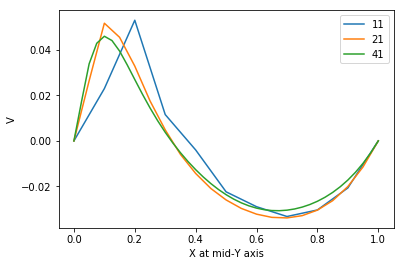

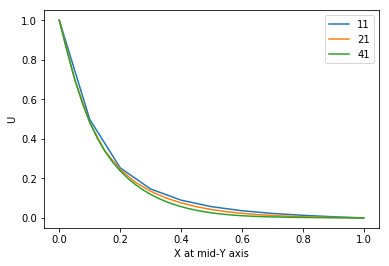

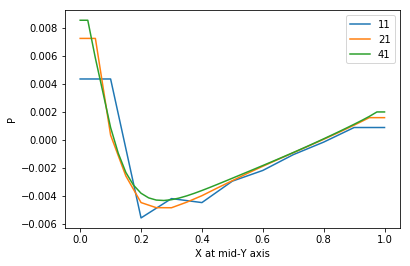

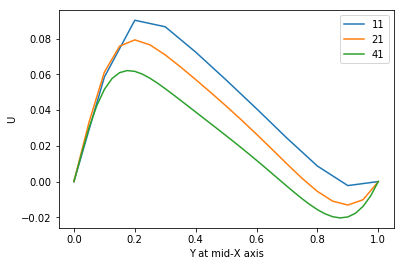

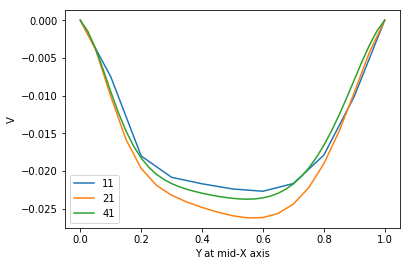

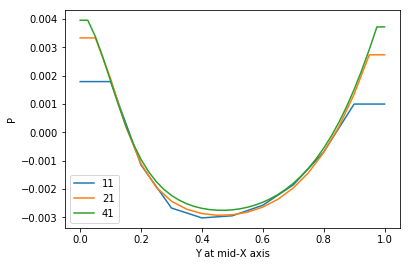

In [9]:
###main##
plt.close('all')
#intialize plots
fig1, ax1 = plt.subplots()    
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()    
fig4, ax4 = plt.subplots()
fig5, ax5 = plt.subplots()    
fig6, ax6 = plt.subplots()
grids =  [11,21,41]
leg = []#list for plot legends
#loop through succesive grid sizes for plotting on one graph
for nx in grids:
    print('Grid size '+str(nx))
    #run time is set very high to allow reaching steady state
    run_time = 20
    #determine dx based on number of nodes
    dx = dy =  1 / (nx - 1)
    #initialize variables
    nu = .01
    u_lid = 1
    Re = 100
    L = 1
    rho = nu*Re/(u_lid*L) #solve for density to show it is =1
    time_step = np.sqrt(dx**2/Re)
    nt = run_time/time_step
    steady_state_criteria = 1e-4
    
    #intial conditions
    v_0 = np.zeros((nx, nx))
    u_0 = np.zeros((nx, nx))
    p = np.zeros((nx, nx)) #for shape
    #working through algorithm with initial u and v to determine intial p at time n=0    
    Hx = define_Hx(u_0,v_0,nu,dx,nx)
    Hy = define_Hy(u_0,v_0,nu,dx,nx)
    P = define_P(p,Hx,Hy,dx,nx,time_step)
    #using p solution at time n=0, find u and v at time n = 1
    U_n = define_u_n1(u_0,time_step,Hx,p,dx,nx)
    V_n = define_v_n1(v_0,time_step,Hy,p,dx,nx)
    N = 1
    #loop to iterate through time until steady state condition is reached
    while N<=nt:
        #print(N)#to show program is running
        Hx = define_Hx(U_n,V_n,nu,dx,nx)
        Hy = define_Hy(U_n,V_n,nu,dx,nx)
        P = define_P(P,Hx,Hy,dx,nx,time_step)
        U_n_1 = define_u_n1(U_n,time_step,Hx,P,dx,nx)
        V_n_1 = define_v_n1(V_n,time_step,Hy,P,dx,nx)
        #check if steady state is reached, if not iterate again
        if (np.abs(np.max(U_n_1-U_n))<=steady_state_criteria)&(np.abs(np.max(V_n_1-V_n))<=steady_state_criteria):
            U_n = U_n_1
            V_n = V_n_1
            print('Steady state at '+str(N*time_step))
            break
        else:
            U_n = U_n_1
            V_n = V_n_1
            N+=1
    
    #make plots after iterations completed
    leg.append(nx)
    ax1.plot(np.linspace(0,1,num=len(U_n)),U_n[:,int((nx-1)/2)])    
    ax2.plot(np.linspace(0,1,num=len(U_n)),V_n[:,int((nx-1)/2)])    
    ax3.plot(np.linspace(0,1,num=len(U_n)),P[:,int((nx-1)/2)])    
    ax4.plot(np.linspace(0,1,num=len(U_n)),V_n[int((nx-1)/2),:])    
    ax5.plot(np.linspace(0,1,num=len(U_n)),U_n[int((nx-1)/2),:])    
    ax6.plot(np.linspace(0,1,num=len(U_n)),P[int((nx-1)/2),:])    
#formatting plots
ax1.set_xlabel('X at mid-Y axis')
ax1.set_ylabel('V')  
ax1.legend(leg) 

ax2.set_xlabel('X at mid-Y axis')
ax2.set_ylabel('U')
ax2.legend(leg) 

ax3.set_xlabel('X at mid-Y axis')
ax3.set_ylabel('P')  
ax3.legend(leg) 

ax4.set_xlabel('Y at mid-X axis')
ax4.set_ylabel('U')
ax4.legend(leg) 

ax5.set_xlabel('Y at mid-X axis')
ax5.set_ylabel('V')  
ax5.legend(leg) 

ax6.set_xlabel('Y at mid-X axis')
ax6.set_ylabel('P')
ax6.legend(leg) 